# CIFAR-10 Image Classification 

## References
###https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

In [ ]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import time
import calendar
from six.moves import cPickle as pickle
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from math import ceil

In [ ]:
# General Parameters

imageSize = 32  
channels = 3    
classes = 10    
trainingDataSize = 50000    
testDataSize = 10000        
trainingDataFiles = ('./dataset/cifar-10-batches-py/data_batch_1', './dataset/cifar-10-batches-py/data_batch_2', './dataset/cifar-10-batches-py/data_batch_3', './dataset/cifar-10-batches-py/data_batch_4','./dataset/cifar-10-batches-py/data_batch_5') 
testDataFile = './dataset/cifar-10-batches-py/test_batch' 

In [ ]:
# Class values

label={}
label[0]='airplane' 
label[1]='automobile' 
label[2]='bird' 
label[3]='cat' 
label[4]='deer' 
label[5]='dog' 
label[6]='frog' 
label[7]='horse' 
label[8]='ship'
label[9]='truck'

In [ ]:
def loadData(filename):
    '''
    Load the data from the given filename

    Parameters:
    -----------
    filename: string
        The name of the file containing the data to load

    Returns:
    --------
    theSet['data']:     array of images
    theSet['labels']:   array of labels
    '''
    f = open(filename, 'rb')
    theSet = pickle.load(f,encoding='latin1')
    f.close()

    return theSet['data'], theSet['labels']

In [ ]:
def convertImages(origImages):
    '''
    Convert the images from CIFAR-10 format, to an array of 10000 images each is 32 X 32 X 3 size

    Parameters:
    -----------
    origImages: array
        array of images in the CIFAR-10 format

    Returns:
    --------
    images:     array of images each in 32 X 32 X 3 size
    '''
    images = np.reshape(origImages,(-1, channels, imageSize, imageSize))
    images = np.transpose(images, (0,2,3,1))

    return images

In [ ]:
def loadTrainingData(filenames):
    '''
    Load all the training data from all files

    Parameters:
    -----------
    filenames: array of string
        An array The name of the file containing the data to load

    Returns:
    --------
    trainingImages: array of the training set images
    trainingLabels: array of the training set labels
    '''

    #Pre-allocate the arrays
    trainingImages = np.zeros(shape=[trainingDataSize, imageSize, imageSize, channels], dtype=np.uint8)
    trainingLabels = np.zeros(shape=[trainingDataSize], dtype=int)

    start=0
    for fileName in filenames:

      origImages, labels = loadData(fileName)
      images = convertImages(origImages)

      numOfImages = len(images)
      end = start + numOfImages
      # print(numOfImages)
      trainingImages[start:end, :] = images
      trainingLabels[start:end] = labels
      start = end

    return trainingImages, trainingLabels

In [ ]:
def loadTestData(filename):
    '''
    Load the test data

    Parameters:
    -----------
    filename: string
        The name of the file containing the test data

    Returns:
    --------
    testImages: array of images of the test data
    testLabels: array of labels of the test data
    '''

    origTestImages, testLabels = loadData(filename)
    testImages = convertImages(origTestImages)

    return testImages, testLabels

In [ ]:
def currentTime():
    '''
    Returns the current time in seconds since EPOC
    Used to measure how much time each phase took

    Returns:
    --------
    the current time in second since EPOC
    '''

    return calendar.timegm(time.gmtime())

In [ ]:
from google.colab import drive
drive.mount('/content/Drive', force_remount=True)

Mounted at /content/Drive


In [ ]:
!mkdir -p "/content/dataset"
!tar -xzf "/content/Drive/MyDrive/CIFAR-10/cifar-10-python.tar.gz" -C "/content/dataset"

tar (child): /content/Drive/MyDrive/CIFAR-10/cifar-10-python.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
print("Loading the training set..."),
tik = currentTime()
trainingImages, trainingLabels = loadTrainingData(trainingDataFiles)
print("Took: " + str(currentTime()-tik) + " sec" )

Loading the training set...


FileNotFoundError: ignored

## Take 5 images per image class for EDA

In [ ]:
list_0 = []
list_1 = []
list_2 = []
list_3 = []
list_4 = []
list_5 = []
list_6 = []
list_7 = []
list_8 = []
list_9 = []

In [ ]:
for i in range(trainingImages.shape[0]):

  if trainingLabels[i] == 0:
    list_0.append(trainingImages[i])

  if trainingLabels[i] == 1:
    list_1.append(trainingImages[i])
    
  if trainingLabels[i] == 2:
    list_2.append(trainingImages[i])
    
  if trainingLabels[i] == 3:
    list_3.append(trainingImages[i])
    
  if trainingLabels[i] == 4:
    list_4.append(trainingImages[i])
    
  if trainingLabels[i] == 5:
    list_5.append(trainingImages[i])
    
  if trainingLabels[i] == 6:
    list_6.append(trainingImages[i])
    
  if trainingLabels[i] == 7:
    list_7.append(trainingImages[i])
    
  if trainingLabels[i] == 8:
    list_8.append(trainingImages[i])
    
  if trainingLabels[i] == 9:
    list_9.append(trainingImages[i])

In [ ]:
num=5

list_0 = list_0[:num]
list_1 = list_1[:num]
list_2 = list_2[:num]
list_3 = list_3[:num]
list_4 = list_4[:num]
list_5 = list_5[:num]
list_6 = list_6[:num]
list_7 = list_7[:num]
list_8 = list_8[:num]
list_9 = list_9[:num]

## HOG Descriptor

In [ ]:
from skimage.transform import resize
def hog_vis(img):
  resized_img = resize(img, (128*4, 128*4))
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
  
  plt.axis("off")
  plt.imshow(img)
  plt.show()
  
  plt.axis("off")
  plt.imshow(hog_image, cmap="gray")
  plt.show()

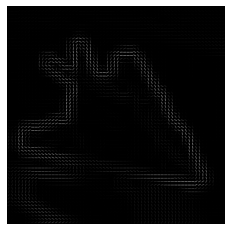

airplane


In [ ]:
hog_vis(list_0[0])
print(label[0])

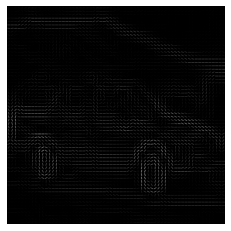

automobile


In [ ]:
hog_vis(list_1[0])
print(label[1])

In [ ]:
hog_vis(list_2[2])
print(label[2])


In [ ]:
hog_vis(list_3[2])
print(label[3])


In [ ]:
hog_vis(list_4[2])
print(label[4])

In [ ]:
hog_vis(list_5[0])
print(label[5])

In [ ]:
hog_vis(list_6[0])
print(label[6])

In [ ]:
hog_vis(list_7[0])
print(label[7])

In [ ]:
hog_vis(list_8[2])
print(label[8])

In [ ]:
hog_vis(list_9[0])
print(label[9])